<h1>Crack Image Detection</h1> 


<h2>Preparation</h2>


In [21]:
# Import the libraries we need to use in this lab

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import numpy as np
import os
import time
from PIL import Image
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
from torch.utils.data import Subset, DataLoader
import skillsnetwork 

<h2>Define dataset class</h2>


In [12]:
# Define your dataset class
class Dataset(Dataset):
    # Constructor
    def __init__(self, transform=None, train=True):
        # Directory of the data
        directory = "C:/Users/ASUS/Documents/Coursera/Coursera Specialization/IBM AI Engineering/AI Capstone Project with Deep Learning/Data/"
        positive = "Positive"
        negative = "Negative"
        
        # Path of the negative and positive data
        positive_file_path = os.path.join(directory, positive)
        negative_file_path = os.path.join(directory, negative)
        
        # Get the data
        positive_files = [os.path.join(positive_file_path, file) for file in os.listdir(positive_file_path)]
        positive_files.sort()
        negative_files = [os.path.join(negative_file_path, file) for file in os.listdir(negative_file_path)]
        negative_files.sort()
        
        number_of_samples = len(positive_files) + len(negative_files)
        
        self.all_files = [None] * number_of_samples
        self.all_files[::2] = positive_files
        self.all_files[1::2] = negative_files 

        self.transform = transform
        
        # Define the target values
        self.Y = torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2] = 1  # Positive class
        self.Y[1::2] = 0  # Negative class
        
        # Define the train and test dataset
        if train:
            self.all_files=self.all_files[0:10000]
            self.Y=self.Y[0:10000]
            self.len=len(self.all_files)
            
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)    

    # Get the length of the dataset
    def __len__(self):
        return self.len

    # Getter to retrieve an image and label pair
    def __getitem__(self, idx):
        image = Image.open(self.all_files[idx]).convert('RGB')  # Ensure all images are RGB
        y = self.Y[idx]

        # If there is a transform, apply it
        if self.transform:
            image = self.transform(image)

        return image, y

In [16]:
class CNN(nn.Module):

    # Contructor
    def __init__(self, out_1=32, out_2=64, out_3=64):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=out_1, kernel_size=3, padding=1)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=3, stride=1, padding=1)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        
        self.cnn3 = nn.Conv2d(in_channels=out_2, out_channels=out_3, kernel_size=3, stride=1, padding=1)
        self.maxpool3=nn.MaxPool2d(kernel_size=2)
        
        self.fc1_input_size = out_3 * 18 * 18
        
        self.fc1 = nn.Linear(self.fc1_input_size, 2)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = self.cnn3(x)
        x = torch.relu(x)
        x = self.maxpool3(x)
        x = x.view(-1, self.fc1_input_size)
        x = self.fc1(x)
        return x

<h2>Define criterion</h2>


In [14]:
def Criterion():
    criterion = nn.CrossEntropyLoss()

    return Criterion

<h2>Define optimizer</h2>


In [15]:
def Optimizer(model, learning_rate):
    lr = learning_rate
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
    
    return optimizer

<h2>Import dataset</h2>


In [25]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define transforms with the computed mean and std
transform_rotate = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Create training and validation datasets using the normalization
train_dataset = Dataset(transform=transform_rotate, train=True)
validation_dataset = Dataset(transform=transform, train=False)

TypeError: Dataset() takes no arguments

In [17]:
# Define the model
model = CNN()

# Define the criterion
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = Optimizer(model, 0.001)

# Define the train and validation dataset loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1)

In [18]:
# Machine learning model
print(model)

CNN(
  (cnn1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=20736, out_features=2, bias=True)
)


<h2>Train the model</h2>


In [22]:
n_epochs=1
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()
#n_epochs

Loss=0
start_time = time.time()
for epoch in range(n_epochs):
    for x, y in train_loader:

        model.train() 
        #clear gradient
        
        optimizer.zero_grad()
        #make a prediction 
        
        z = model(x)
        # calculate loss 
        
        loss = criterion(z, y)
        # calculate gradients of parameters
        
        loss.backward()
        # update parameters
        
        optimizer.step()
        loss_list.append(loss.data)
    correct=0
    
    for x_test, y_test in validation_loader:
        # set model to eval 
        model.eval()
        
        #make a prediction 
        z = model(x_test)
        
        #find max 
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y_test).sum().item()
        
        #Calculate misclassified  samples in mini-batch 
        #hint +=(yhat==y_test).sum().item()
    accuracy = correct / N_test
    accuracy_list.append(accuracy)
   
    accuracy=correct/N_test

In [23]:
accuracy

0.9604

Text(0.5, 1.0, 'Loss vs Iteration')

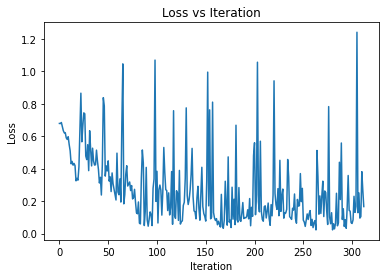

In [24]:
# Plot the loss and accuracy

plt.plot( loss_list)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs Iteration')